In [115]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
import surprise 
from sklearn.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise import SVD

In [6]:
os.getcwd()

'/Users/dimitrikestenbaum/Desktop/RecSys'

In [9]:
artist_df = pd.read_table('Data-20220224/Data Group Assignment/Artists.dat')

In [18]:
artist_df.head()

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [17]:
tags_df = pd.read_table('Data-20220224/Data Group Assignment/tags.dat',encoding='latin-1')

In [19]:
tags_df.head()

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


In [13]:
user_artists_df = pd.read_table('Data-20220224/Data Group Assignment/user_artists.dat')

In [46]:
user_artists_df.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [15]:
user_taggedartists_df = pd.read_table('Data-20220224/Data Group Assignment/user_taggedartists.dat')

In [21]:
user_taggedartists_df.head()

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009


## Collaborative Filtering

### User-Based KNN 

(0.0, 352698.0)

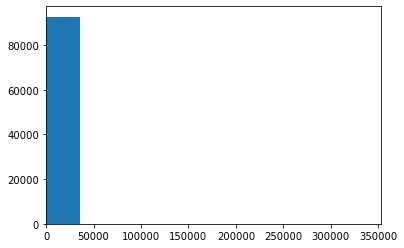

In [39]:
#entire range of weights
plt.hist(user_artists_df.weight)
plt.xlim(0,user_artists_df.weight.max())

(0.0, 50000.0)

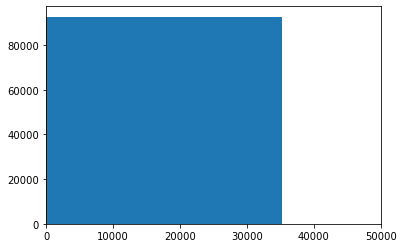

In [53]:
plt.hist(user_artists_df.weight)
plt.xlim(0,50000)

In [49]:
user_artists_df.iloc[user_artists_df['weight'].idxmax()]

userID        1642
artistID        72
weight      352698
Name: 72739, dtype: int64

In [50]:
user_artists_df.weight.value_counts()

1        636
2        419
4        345
3        338
5        318
        ... 
13005      1
4287       1
4832       1
2760       1
14690      1
Name: weight, Length: 5436, dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x7f86b1991a30>,
 'caps': [<matplotlib.lines.Line2D at 0x7f86b186b820>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f86b1991cd0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f86b186bbb0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f86b186b8b0>],
 'means': []}

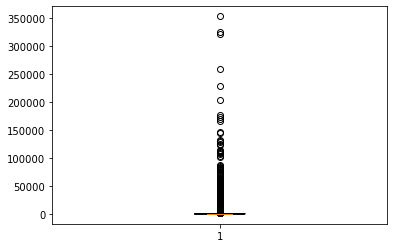

In [56]:
plt.boxplot(user_artists_df.weight, notch=True)

In [63]:
user_artists_df.weight.describe()

count     92834.00000
mean        745.24393
std        3751.32208
min           1.00000
25%         107.00000
50%         260.00000
75%         614.00000
max      352698.00000
Name: weight, dtype: float64

In [79]:
#discretize weights using qcuts 
user_artists_df['weight_quantiles'] = pd.qcut(user_artists_df['weight'],
                           q=[0,.2,.4,.6,.8,1],
                           labels=False,
                           precision=0)

In [81]:
user_artists_df.weight_quantiles.value_counts()

0    18770
3    18581
4    18548
2    18469
1    18466
Name: weight_quantiles, dtype: int64

In [82]:
#new df only replacing the countinous and skewed weights with the new discretized weight var
UA_df_cf = user_artists_df[['userID','artistID','weight_quantiles']]

In [87]:
#create train and test sets 
UA_train, UA_test = train_test_split(UA_df_cf,test_size=0.3,random_state=123)

UA_train = UA_train.reset_index(drop=True)
UA_test = UA_test.reset_index(drop=True)

In [107]:
#create reader object 
reader = surprise.Reader(rating_scale=(1,5)) #1:5 scale 

#create surprise train and test set objects
data = surprise.Dataset.load_from_df(UA_df_cf[["userID","artistID","weight_quantiles"]], reader)
UA_train = surprise.Dataset.load_from_df(UA_train, reader).build_full_trainset()
UA_test = list(UA_test.itertuples(index=False, name=None))

In [110]:
#get baseline KNN score 
from surprise import KNNBasic

# create options dict; use cosine similarity on user_based data
options = {'name':'cosine', 'user_based':True}

ubKNN = KNNBasic(k=20, min_k=5, sim_options=options, random_state=123)

#create cosine similarity matrix
ubKNN.fit(UA_train)\
.compute_similarities()


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


array([[1.        , 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 1.        , 0.96559438, ..., 0.        , 0.        ,
        1.        ],
       [1.        , 0.96559438, 1.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 1.        , 1.        , ..., 0.        , 0.        ,
        1.        ]])

In [102]:
from surprise import accuracy

ubKNNpreds = ubKNN.test(UA_test)

ubKNNAccuracy = accuracy.rmse(ubKNNpreds)

# percentage impossible predictions
perc_impossible = np.sum([1 for i in ubKNNpreds if i.details["was_impossible"]]) / len(ubKNNpreds)
print(f"Impossible: {perc_impossible:.4f}")

RMSE: 1.3942
Impossible: 0.3796


In [103]:
ubKNN.default_prediction()

1.9962759490943784

In [119]:
#grid search cross validation

param_grid = {'k':[5,10,20,30],
             'min_k':[2,5,10]}

#5-fold grid searched cv 
ubKNN_cv_grid = GridSearchCV(KNNBasic,
                             param_grid=param_grid,
                            measures=['rmse','mae'],
                            cv=5)
ubKNN_cv_grid.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [121]:
print(f"Best params with respect to RMSE: ",ubKNN_cv_grid.best_params['rmse'])
print(f"Best params with respect to MAE: ",ubKNN_cv_grid.best_params['mae'])

Best params with respect to RMSE:  {'k': 20, 'min_k': 2}
Best params with respect to MAE:  {'k': 10, 'min_k': 2}


In [122]:
print(f"Best score with respect to RMSE: ",ubKNN_cv_grid.best_score['rmse'])
print(f"Best score with respect to MAE: ",ubKNN_cv_grid.best_score['mae'])

Best score with respect to RMSE:  1.1964620194863116
Best score with respect to MAE:  0.9859837937765368
